In [11]:
import os, time, cv2
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [153]:
class StitchBase(ABC):
    def __init__(self, config):
        self.rng = np.random.default_rng(config["seed"])     
        self.ratio_test = config["ratio_test"]
        self.tolerance = config["tolerance"]
        self.outlier_rate = config["outlier_rate"]
        self.max_iter = config["max_iter"]

    @staticmethod
    def read_img(folder, size):
        if size is not None:    return np.stack([cv2.resize(cv2.imread(f"{folder}/{img}"), size) for img in os.listdir(folder)])
        else:                   return np.stack([cv2.imread(f"{folder}/{img}") for img in os.listdir(folder)])

    @staticmethod
    def expand(points):
        return np.vstack([points.T, np.ones_like(points.T[-1])])
    
    def rand_comb(self, n, r=4):
        return sorted(self.rng.choice(n, r, replace=False))
    
    @staticmethod
    def SIFT_img(img):
        SIFT = cv2.SIFT_create()
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        data = SIFT.detectAndCompute(img_gray, None)
        kpts = np.stack(np.vectorize(lambda kpt: kpt.pt)(data[0])).T
        feature = data[1]
        return kpts, feature
    
    def find_matches(self, f1, f2):
        # generate l2-norm distance matrix similarity, similarity[i, j] = l2-norm(a1[i] - a2[j])
        similarity = np.vectorize(lambda v1, a2: np.linalg.norm(v1 - a2, axis=1), excluded=["a2"],
                                signature="(n),(m,n)->(m)")(f1, f2)
        # get two highest index and value of similarity
        two_lowest_index = np.argpartition(similarity, 2)[:, :2]
        two_lowest_value = np.take_along_axis(similarity, two_lowest_index, axis=1)
        # ratio test
        good_match = two_lowest_value[:, 0] < self.ratio_test * two_lowest_value[:, 1]
        # generate matching matrix based on good_match
        kpts1 = np.arange(f1.shape[0])[good_match]
        kpts2 = two_lowest_index[good_match, 0]
        return kpts1, kpts2
    
    @staticmethod
    def homography(m1, m2):
        A = np.zeros((8, 8))
        A[:4, :2] = m1
        A[:4, 2] = 1
        A[4:, 3:5] = m1
        A[4:, 5] = 1
        A[:4, 6] = -m1[:, 0] * m2[:, 0]
        A[:4, 7] = -m1[:, 1] * m2[:, 0]
        A[4:, 6] = -m1[:, 0] * m2[:, 1]
        A[4:, 7] = -m1[:, 1] * m2[:, 1]
        b = np.hstack([m2[:, 0], m2[:, 1]])
        h = np.linalg.lstsq(A, b, rcond=None)[0]
        return np.append(h, 1).reshape(3, 3)
    
    def calculate_outlier(self, H, m1, m2):
        m2_hat = H @ m1
        m2_hat = m2_hat / np.where(m2_hat[2] != 0, m2_hat[2], 1)
        return (np.linalg.norm(m2[:2] - m2_hat[:2], axis=0) > self.tolerance).sum()
    
    @staticmethod
    def img_mask(img_1, img_2):
        gray_1, gray_2 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
        mask_1, mask_2 = gray_1 != 0, gray_2 != 0
        mask_all = np.logical_or(mask_1, mask_2)
        return gray_1, gray_2, mask_1, mask_2, mask_all
    
    @staticmethod
    def gap_blend(img_1, img_2, img_3, gray_1, gray_2, mask_all, threshold=125):
        img_sum = gray_1.astype(float) + gray_2.astype(float)
        weight_1 = np.divide(gray_1, img_sum, out=np.ones_like(gray_1, dtype=float), where=img_sum != 0)
        weight_2 = 1 - weight_1

        patch = np.zeros_like(img_1)
        for i in range(3):
            patch[:, :, i] = weight_1 * img_1[:, :, i] + weight_2 * img_2[:, :, i]

        fix = np.logical_and(cv2.cvtColor(img_3, cv2.COLOR_BGR2GRAY) < threshold, mask_all)
        img_3[fix] = patch[fix]
        return img_3
    
    @staticmethod
    def wrap_imgs(H, addition, base):
        h1, w1, _ = addition.shape
        h2, w2, _ = base.shape
        corners = cv2.perspectiveTransform(np.float32([[0, 0], [w1, 0], [0, h1], [w1, h1]]).reshape(-1, 1, 2), H).squeeze()

        min_x, max_x = 0, w1
        min_y, max_y = 0, h1
        for img_3 in corners:
            min_x = img_3[0] if img_3[0] < min_x else min_x
            max_x = img_3[0] if img_3[0] > max_x else max_x
            min_y = img_3[1] if img_3[1] < min_y else min_y
            max_y = img_3[1] if img_3[1] > max_y else max_y

        delta_x = -(min_x if min_x < 0 else 0)
        delta_y = -(min_y if min_y < 0 else 0)

        A = np.eye(3)
        A[:2, 2] = [delta_x, delta_y]

        new_w = int(max_x - min_x) if max_x - min_x > (w2 + delta_x) else int(w2 + delta_x)
        new_h = int(max_y - min_y) if max_y - min_y > (h2 + delta_y) else int(h2 + delta_y)

        img_1 = cv2.warpPerspective(base, A, (new_w, new_h))
        img_2 = cv2.warpPerspective(addition, A @ H, (new_w, new_h))
        
        # use this to debug
        return cv2.addWeighted(img_1, 0.5, img_2, 0.5, 0)

        # use this to do image blending
        gray_1, gray_2, mask_1, mask_2, mask_all = img_mask(img_1, img_2)
        img_3 = img_1.copy()
        img_3[mask_2] = img_2[mask_2]
        img_3 = gap_blend(img_1, img_2, img_3, gray_1, gray_2, mask_all)
        return img_3
    
    @abstractmethod
    def fit(self, base, addition):
        raise NotImplementedError
    
    def run(self, folder, size=None):
        RGB = self.read_img(folder, size)
        t = time.time()
        
        base_img = RGB[0]
        recs = []
        for img in RGB[1:]:
            kpts_base, feature_base = self.SIFT_img(base_img)
            kpts_addition, feature_addition = self.SIFT_img(img)

            index_base, index_addition = self.find_matches(feature_base, feature_addition)
            H, rec = self.fit(kpts_base[index_base], kpts_addition[index_addition])
            recs.append(rec)
            base_img = self.wrap_imgs(H, img, base_img)

        # cv2.imwrite("evo_img.jpg", base_img)
        return cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB), recs, time.time() - t
    
class RANSAC(StitchBase):
    def __init__(self, config):
        super(RANSAC, self).__init__(config)
    
    def fit(self, base, addition):
        match_counts = base.shape[0]
        points_base, points_addition = self.expand(base), self.expand(addition)
        outlier_cnt, threshold = match_counts, match_counts * self.outlier_rate
        iter, min_outlier, argmin_H = 0, match_counts, None
        rec = []
        while outlier_cnt > threshold and iter <= self.max_iter:
            # print(iter)
            picked = self.rand_comb(match_counts)
            picked_points_base, picked_points_addition = points_base.T[picked, :2], points_addition.T[picked, :2]
            temp_H = self.homography(picked_points_addition, picked_points_base)
            test_points = temp_H @ points_addition
            test_points = test_points / np.where(test_points[2] != 0, test_points[2], 1)
            outlier_cnt = (np.linalg.norm(points_base[:2] - test_points[:2], axis=0) > self.tolerance).sum()
            rec.append(outlier_cnt)
            iter += 1
            if outlier_cnt < min_outlier:
                min_outlier = outlier_cnt
                argmin_H = temp_H
        return argmin_H, rec
    
class EVOSAC(StitchBase):
    def __init__(self, config):        
        super(EVOSAC, self).__init__(config)
        self.lamb = config["mutation_factor"]
        if config["strategy"] == 'ROULETTE':
            self.selection_strategy = self._roulette_selection
        elif config["strategy"] == 'TOURNAMENT':
            self.selection_strategy = self._tournament_selection

        if config["1/5-rule"]:
            self._one_fifth_enable = True
            self.threshold = config["1/5-rule-threshold"]
            self.period = config["1/5-rule-iter"]
            self.alpha = config["1/5-rule-alpha"]
        else:
            self._one_fifth_enable = False
    
    # a set must not contain duplicate numbers
    def _reproduce(self, parent: np.ndarray, match_counts: int):
        duplicate = True
        # concatenate two chromosome
        combine = parent.flatten()
        while duplicate:
            # adding several random integers (size is based on poisson distribution) to the chromosomes
            # shuffle
            # cut the whole array in half
            # check whether each half contains duplicate numbers
            random = self.rng.choice(range(match_counts), self.rng.poisson(self.lamb, 1)[0], replace=False)
            mutation = np.concatenate([combine, random])
            self.rng.shuffle(mutation)
            c1, c2 = sorted(mutation[0:4]), sorted(mutation[4:8])
            duplicate = False
            for i in range(1, 4):
                if c1[i] == c1[i-1] or c2[i] == c2[i-1]:
                    duplicate = True
                    break
        return c1, c2
    
    def _roulette_selection(self, population, fits, pairs):
        fits = fits / np.sum(fits)
        parents = self.rng.choice(population, size=(pairs, 2), replace=True, p=fits)
        return parents

    def _tournament_selection(self, population, fits, pairs):
        sz = population.shape[0]
        def _find_one():
            indices = self.rng.choice(sz, size=2, replace=True)
            return population[indices[0]] if fits[indices[0]] > fits[indices[1]] else population[indices[1]]
        return np.array([(_find_one(), _find_one()) for _ in range(sz >> 1)], dtype=int)

    def _one_fifth(self, counter):
        if counter > self.period * self.threshold:
            self.lamb = self.lamb / self.alpha
        else:
            self.lamb = self.lamb * self.alpha
    
    def fit(self, base, addition):
        match_counts = base.shape[0]
        points_base, points_addition = self.expand(base), self.expand(addition)
        threshold = match_counts * self.outlier_rate
        iter, max_inlier, argmax_H = 0, 0, None
        if self._one_fifth_enable:
            counter = 0
            prev_avg_inlier = 0

        # population = np.arange(match_counts // 4 * 4, dtype=np.uint32).reshape(4, -1).T
        population = self.rng.choice(match_counts, size=match_counts // 4 * 4, replace=False).reshape(-1, 4)
        rec = []
        while (match_counts - max_inlier) > threshold and iter <= self.max_iter:
            Hs = [self.homography(points_addition.T[points, :2], points_base.T[points, :2]) for points in population]
            fits = [match_counts - self.calculate_outlier(H, points_addition, points_base) for H in Hs]
            argmax_fit = np.argmax(fits)
            rec.append(match_counts - fits[argmax_fit])

            if fits[argmax_fit] > max_inlier:
                max_inlier = fits[argmax_fit]
                argmax_H = Hs[argmax_fit]

            parents = self.selection_strategy(population, fits, population.shape[0] // 2)
            
            # TODO: mutation
            # children = np.empty_like(population, dtype=population.dtype)
            for i in range(parents.shape[0]):
                population[2*i], population[2*i+1] = self._reproduce(parents[i], match_counts)
            # population = children
            iter += 1

            if self._one_fifth_enable:
                if np.average(fits) > prev_avg_inlier:
                    counter += 1
                prev_avg_inlier = np.average(fits)
                if iter % self.period == 0:
                    self._one_fifth(counter)
                    counter = 0
        return argmax_H, rec

In [15]:
def plot(info):
    gs = gridspec.GridSpec(4, 6)

    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0:3, 0:3])
    ax1.imshow(info["RANSAC_IMG"])
    ax1.set_title(f"RANSAC: {info['RANSAC_TIME']:.3f} sec")
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0:3, 3:6])
    ax2.imshow(info["EVOSAC_IMG"])
    ax2.set_title(f"EVOSAC: {info['EVOSAC_TIME']:.3f} sec")
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[-1, 0:3])
    for r in info["RANSAC_REC"]:
        ax3.plot(r)
    ax3.set_xlim(0, max([len(rec) for rec in info["RANSAC_REC"]]))
    ax3.set_title(f"RANSAC outlier record")
        
    ax4 = fig.add_subplot(gs[-1, 3:6])
    for r in info["EVOSAC_REC"]:
        ax4.plot(r)
    ax4.set_xlim(0, max([len(rec) for rec in info["EVOSAC_REC"]]))
    ax4.set_title(f"EVOSAC outlier record")
        
    plt.savefig("result.png", dpi=300)
    plt.show()

Running RANSAC... 1701805759.1865826
Running EVOSAC... 1701805759.9545944


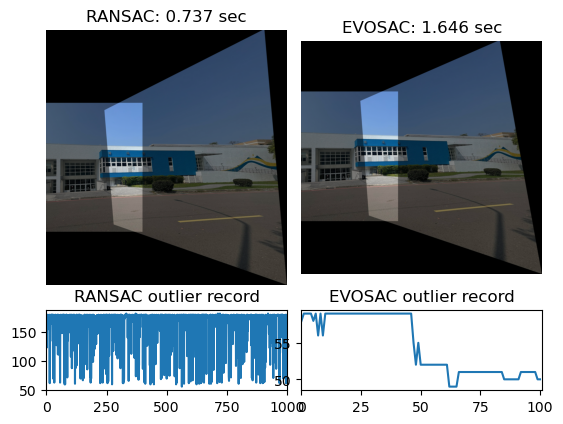

55 49


In [155]:
info = {}
# Since the complexity of match finding is O(N1N2), where Ni is number of key-points.
# If the image resolution is higher, number of key-points grows too
# In this case, just lower the resolution would be fine
folder, size = "./baseline", None   # resolution (h, w), use None to perserve the original size
ransac_config = {
    "seed": 0,
    "ratio_test": 0.7,
    'tolerance': 4,
    "outlier_rate": 0.1,
    "max_iter": 1000
}
print('Running RANSAC...', time.time())
ransac = RANSAC(ransac_config)
info["RANSAC_IMG"], info["RANSAC_REC"], info["RANSAC_TIME"] = ransac.run(folder, size)

evosac_config = {
    "seed": 10,
    "ratio_test": 0.7,
    'tolerance': 4,
    "outlier_rate": 0.1,
    "max_iter": 100,
    'mutation_factor': 0.5,
    '1/5-rule': False,
    '1/5-rule-threshold': 0.1,
    '1/5-rule-iter': 50,
    '1/5-rule-alpha': 0.9,
    'strategy': 'TOURNAMENT'
}
print('Running EVOSAC...', time.time())
evosac = EVOSAC(evosac_config)
info["EVOSAC_IMG"], info["EVOSAC_REC"], info["EVOSAC_TIME"] = evosac.run(folder, size)
plot(info)
# print(info["RANSAC_REC"][0])
# print(info["EVOSAC_REC"][0])
print(min(info["RANSAC_REC"][0]), min(info["EVOSAC_REC"][0]))